## Diffusion Model to generate pulmonary 2DCT 

### Pre-processing images

In [8]:
#Collecting relevant slices

from glob import glob

image_paths = glob('/kaggle/input/lidcidri/LIDC-IDRI-slices/*/*/images/*.png')
image_paths[0]

'/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-IDRI-0698/nodule-0/images/slice-6.png'

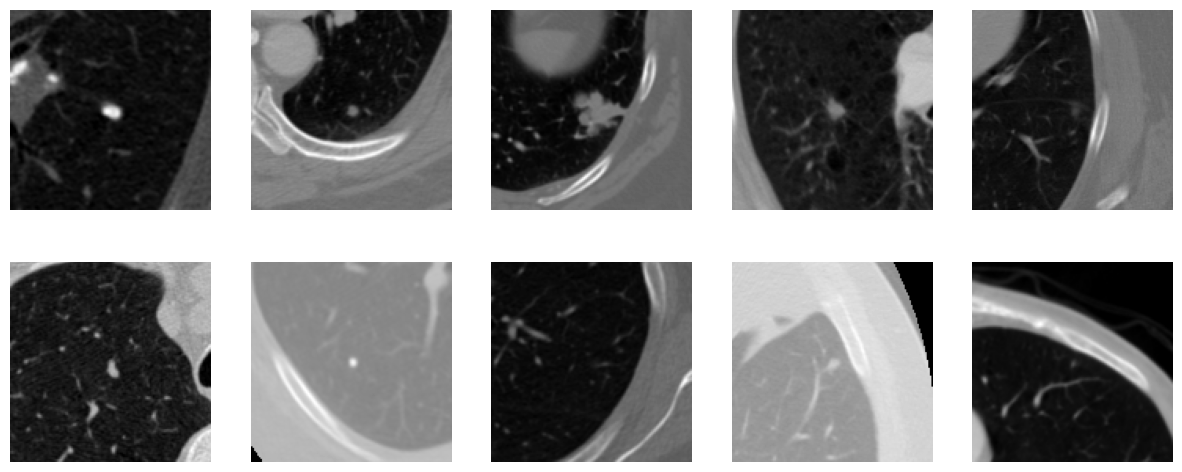

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random

random_files = random.choices(image_paths, k = 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, file in enumerate(random_files):
    img = np.asarray(cv.imread(file, 0))  
    axes[i // 5, i % 5].imshow(img, cmap='gray')
    axes[i // 5, i % 5].axis("off")
plt.show()


In [10]:
#Number of samples
print(f'Number of samples: {len(image_paths)}')

Number of samples: 15548


In [11]:
def normalize_image(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) 
    image = (image * 2) - 1  # [-1,1] for better training of diffusion model
    return image
    
def resize_image(image, size=(256, 256)):
    return cv.resize(image, size, interpolation=cv.INTER_LINEAR)


In [12]:
"""Complete pre processing pipeline"""

pre_processed_slices = []
for image in sorted(image_paths):
    im = cv.imread(image, 0)
    norm = normalize_image(im)
    resized = resize_image(norm)
    pre_processed_slices.append(resized)


preprocessed_slices = np.array(pre_processed_slices)

### Creating the Data Loader and Augmenting Data

In [13]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class LIDC_Dataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        """
        Args:
            npy_path (str): Path to preprocessed LIDC slices (.npy file).
            transform (callable, optional): Optional transform to apply.
            augment (bool): If True, applies Albumentations augmentations.
        """
        self.data = data
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]

        # Convert to uint8 for Albumentations (expects 0-255)
        image = ((image + 1) / 2 * 255).astype(np.uint8)

        if self.augment:
            image = augmentation(image=image)["image"]  # Apply augmentations

        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)  

        return image

In [15]:
"""Defining medical specific augmentations"""
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline
augmentation = A.Compose([
    A.RandomBrightnessContrast(
         brightness_limit=0.2,
         contrast_limit=0.2,
         brightness_by_max=False,
        p=1.0),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),  
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3), 
    A.Resize(256, 256),  
    ToTensorV2() 
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [16]:
from torch.utils.data import random_split

full_dataset = LIDC_Dataset(data= preprocessed_slices, augment=True)

train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10
total_size = len(full_dataset)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")


Train: 11661, Val: 2332, Test: 1555


<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

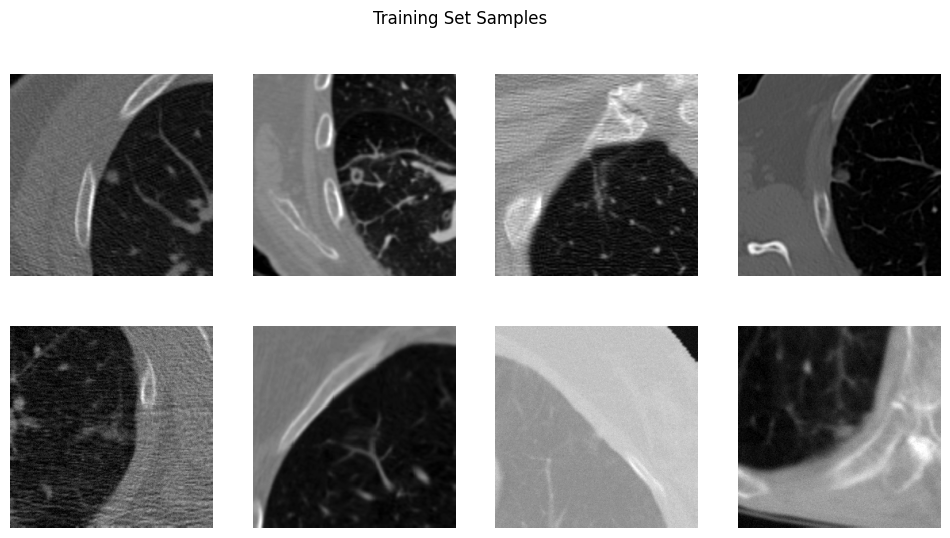

<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

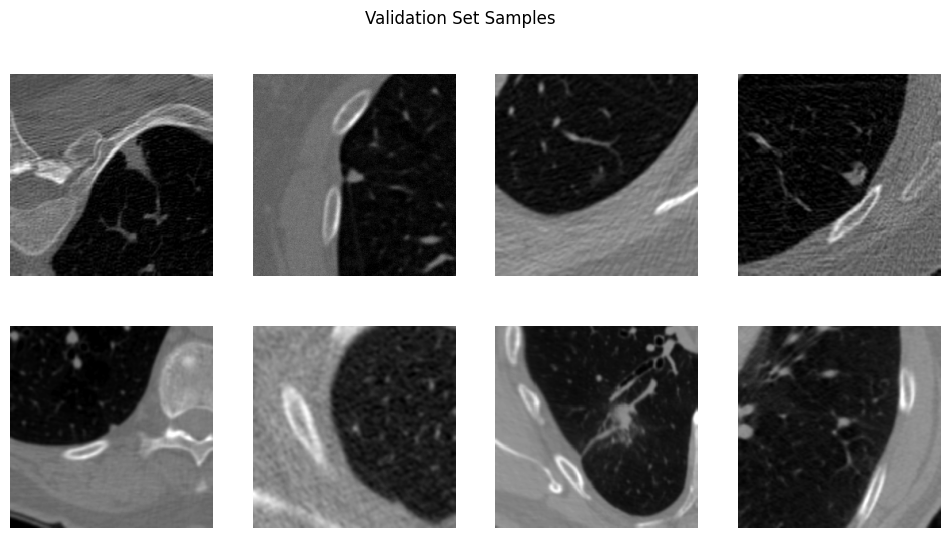

<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

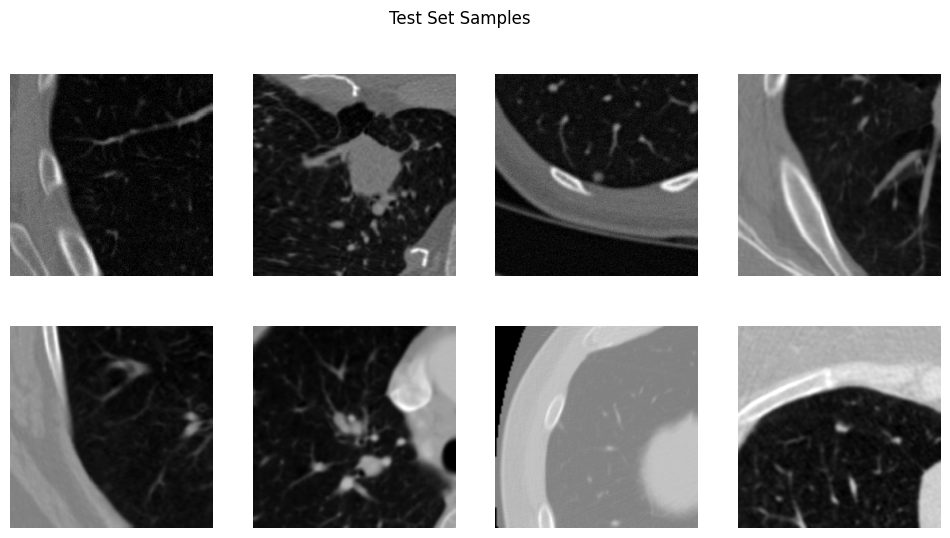

In [17]:
# Function to show images
def show_batch(images, title):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(0), cmap="gray")  # Remove channel dim
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

# Show training set batch
train_batch = next(iter(train_loader))
show_batch(train_batch, "Training Set Samples")

# Show validation set batch
val_batch = next(iter(val_loader))
show_batch(val_batch, "Validation Set Samples")

# Show test set batch
test_batch = next(iter(test_loader))
show_batch(test_batch, "Test Set Samples")


### Setting up the forward pass

In [18]:
import torch

def linear_beta_schedule(timesteps, start=1e-4, end=0.02, device = 'cpu'):
    return torch.linspace(start, end, timesteps, device = device)

def calculate_alphas(betas, device = 'cpu'):
    alphas = 1.0 - betas
    alpha_cumprod = torch.cumprod(alphas, dim=0) 
    return alphas, alpha_cumprod

def forward_diffusion(x_0, t, alpha_cumprod, device="cpu"):
    noise = torch.randn_like(x_0).to(device)  
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod[t]).view(-1, 1, 1, 1).to(device)

    x_t = sqrt_alpha_cumprod * x_0 + sqrt_one_minus_alpha_cumprod * noise
    return x_t, noise  


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
T = 1000  
betas = linear_beta_schedule(T, device = device)  
_, alpha_cumprod = calculate_alphas(betas, device = device)  

train_batch = next(iter(train_loader)).to(device)  

timesteps = torch.randint(0, T, (train_batch.shape[0],), device=device)

noisy_images, noise = forward_diffusion(train_batch, timesteps, alpha_cumprod, device)

<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

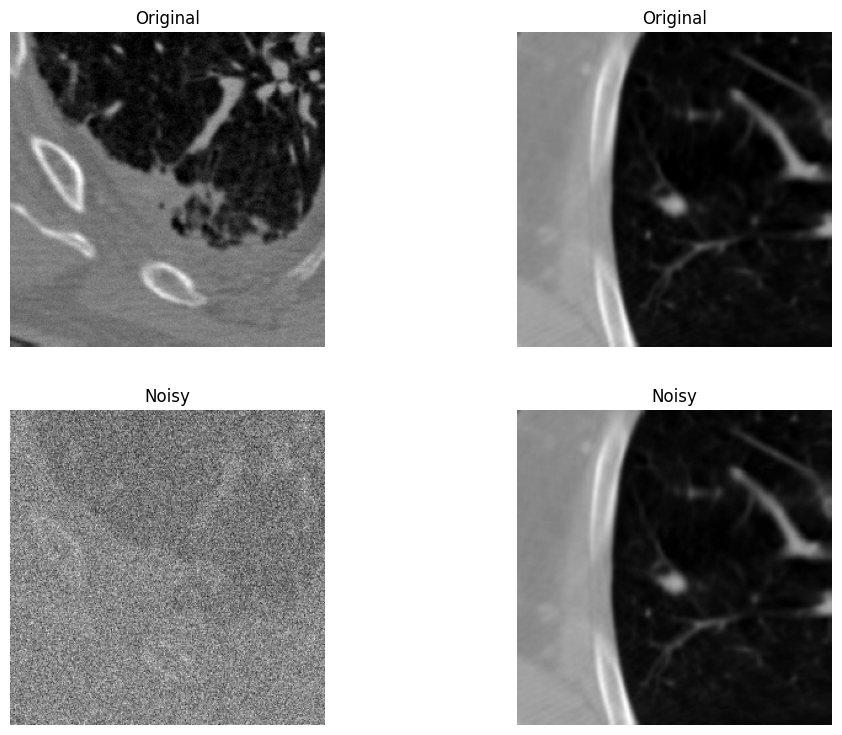

In [20]:
import matplotlib.pyplot as plt

def visualize_noise(train_batch, noisy_images, noise, num_samples=2):
    num_samples = min(num_samples, train_batch.shape[0]) 
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 9))

    for i in range(num_samples):
        # Original Image
        axes[0, i].imshow(train_batch[i].cpu().squeeze(0), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        # Noisy Image
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(0), cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title("Noisy")

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Noisy")
    
    plt.show()

# Call the function to visualize the noise
visualize_noise(train_batch, noisy_images, noise)


### Creating a UNET to denoise the image

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.encoder.append(self._conv_block(in_channels, feature))
            in_channels = feature

        self.bottleneck = self._conv_block(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._conv_block(feature * 2, feature))

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)


        x = self.bottleneck(x)

        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)  
            skip = skip_connections[-(i//2 + 1)]  
            x = torch.cat((skip, x), dim=1)  
            x = self.decoder[i+1](x)  

        return self.final_layer(x)  

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.3)
        )


In [22]:
"""Defining a loss funciton"""
def noise_loss(predicted_noise, true_noise):
    return F.mse_loss(predicted_noise, true_noise)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_batch = next(iter(train_loader)).to(device)
timesteps = torch.randint(0, T, (train_batch.shape[0],), device=device)

noisy_images, true_noise = forward_diffusion(train_batch, timesteps, alpha_cumprod, device = device)

model = UNet().to(device)
predicted_noise = model(noisy_images)

print("Noisy Image Shape:", noisy_images.shape)      
print("True Noise Shape:", true_noise.shape)
print("Predicted Noise Shape:", predicted_noise.shape)  

<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

Noisy Image Shape: torch.Size([8, 1, 256, 256])
True Noise Shape: torch.Size([8, 1, 256, 256])
Predicted Noise Shape: torch.Size([8, 1, 256, 256])


In [25]:
pip install pytorch-fid


Note: you may need to restart the kernel to use updated packages.


In [36]:
from pytorch_fid import fid_score
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  
    max_pixel = 1.0  
    return 10 * torch.log10(max_pixel**2 / mse)
    
def compute_ssim(img1, img2):
    img1 = img1.detach().cpu().squeeze().numpy()  # Detach and move to CPU before converting
    img2 = img2.detach().cpu().squeeze().numpy()
    return ssim(img1, img2, data_range=1.0)


def compute_fid(real_images, generated_images):
    fid_value = fid_score.calculate_fid_given_paths(real_images, generated_images, batch_size=8, device=device, dims=2048)
    return fid_value


### Train the network

In [37]:
from torch import optim
LEARNING_RATE = 2e-4
EPOCHS = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
epochs = EPOCHS  # Start small, can increase later
best_val_loss = float("inf")  # Track the lowest validation loss

In [ ]:
from tqdm import tqdm

best_val_loss = float("inf")

for epoch in range(epochs):
    model.train()
    total_train_loss, total_psnr, total_ssim = 0, 0, 0

    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)
    for images in train_progress:
        images = images.to(device)
        t = torch.randint(0, T, (images.shape[0],), device=device)
        noisy_images, true_noise = forward_diffusion(images, t, alpha_cumprod, device)

        optimizer.zero_grad()
        predicted_noise = model(noisy_images)
        loss = noise_loss(predicted_noise, true_noise)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Reverse diffusion for evaluation
        reconstructed_images = noisy_images - predicted_noise

        # Compute additional metrics
        total_psnr += psnr(images, reconstructed_images)
        total_ssim += compute_ssim(images, reconstructed_images)

        train_progress.set_postfix(loss=f"{loss.item():.6f}")

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_psnr = total_psnr / len(train_loader)
    avg_train_ssim = total_ssim / len(train_loader)

    # ============================
    # 🔥 Validation Loop
    # ============================
    model.eval()
    total_val_loss, total_val_psnr, total_val_ssim = 0, 0, 0

    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
        for images in val_progress:
            images = images.to(device)
            t = torch.randint(0, T, (images.shape[0],), device=device)
            noisy_images, true_noise = forward_diffusion(images, t, alpha_cumprod, device)
            
            predicted_noise = model(noisy_images)
            loss = noise_loss(predicted_noise, true_noise)

            total_val_loss += loss.item()
            val_progress.set_postfix(loss=f"{loss.item():.6f}")

            # Reverse diffusion for evaluation
            reconstructed_images = noisy_images - predicted_noise

            # Compute additional metrics
            total_val_psnr += psnr(images, reconstructed_images)
            total_val_ssim += compute_ssim(images, reconstructed_images)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_psnr = total_val_psnr / len(val_loader)
    avg_val_ssim = total_val_ssim / len(val_loader)

    print(f"\nEpoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    print(f"Train PSNR: {avg_train_psnr:.2f} | Val PSNR: {avg_val_psnr:.2f}")
    print(f"Train SSIM: {avg_train_ssim:.4f} | Val SSIM: {avg_val_ssim:.4f}")

    # ============================
    # 🔥 Save Best Model
    # ============================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "/kaggle/working/best_diffusion_model.pth")
        print(f"✅ Saved Best Model (Val Loss: {best_val_loss:.6f})")


Epoch 1/10 [Training]:   0%|          | 0/1458 [00:00<?, ?it/s]<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-14-1c01ad08caf1>:28: UserWarning: To copy construct from a tensor, it is 